In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-

In [3]:
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import evaluate
import time
import pandas as pd

2025-04-27 23:02:40.750826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745794960.917830      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745794960.965778      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
common_voice = load_dataset("mozilla-foundation/common_voice_14_0", "ru", split="test", trust_remote_code=True)
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))
samples = common_voice.select(range(100))

README.md:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

common_voice_14_0.py:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

n_shards.json:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

ru_train_0.tar:   0%|          | 0.00/973M [00:00<?, ?B/s]

ru_dev_0.tar:   0%|          | 0.00/396M [00:00<?, ?B/s]

ru_test_0.tar:   0%|          | 0.00/398M [00:00<?, ?B/s]

ru_other_0.tar:   0%|          | 0.00/412M [00:00<?, ?B/s]

ru_invalidated_0.tar:   0%|          | 0.00/374M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/7.87M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/3.00M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/2.93M [00:00<?, ?B/s]

other.tsv:   0%|          | 0.00/3.66M [00:00<?, ?B/s]

invalidated.tsv:   0%|          | 0.00/2.95M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 12651it [00:00, 126501.68it/s]
Reading metadata...: 26316it [00:00, 123787.86it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10194it [00:00, 154788.40it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10194it [00:00, 157698.28it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 11569it [00:00, 143665.55it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 9666it [00:00, 151772.18it/s]


In [31]:
models_info = {
    "openai/whisper-tiny": 39,
    "openai/whisper-base": 74,
    "openai/whisper-small": 244,
    "openai/whisper-medium": 769,
}

In [32]:
wer_metric = evaluate.load("wer")
device = "cuda" if torch.cuda.is_available() else "cpu"
results = []

In [33]:
for model_name, num_params_million in models_info.items():
    print(f"\n Evaluating {model_name}...")
        
    model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
    model.eval()

    predictions = []
    references = []

    start_time = time.time()

    for example in samples:
        inputs = processor(
            example["audio"]["array"],
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features.to(device)

        with torch.no_grad():
            generated_ids = model.generate(inputs)

        transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].lower()
        reference = example["sentence"].lower()

        predictions.append(transcription)
        references.append(reference)

    end_time = time.time()
    wer = wer_metric.compute(predictions=predictions, references=references)
    elapsed = end_time - start_time
    avg_time = elapsed / len(samples)

    results.append({
        "Model": model_name.split("/")[-1],
        "Params (M)": num_params_million,
        "WER": round(wer, 4),
        "Total Time (s)": round(elapsed, 2),
        "Time per Sample (s)": round(avg_time, 3)
    })


🚀 Evaluating openai/whisper-tiny...

🚀 Evaluating openai/whisper-base...

🚀 Evaluating openai/whisper-small...

🚀 Evaluating openai/whisper-medium...


In [34]:
df = pd.DataFrame(results)
df_sorted = df.sort_values("WER")

In [35]:
print(df_sorted)

            Model  Params (M)     WER  Total Time (s)  Time per Sample (s)
3  whisper-medium         769  0.2835           81.25                0.812
2   whisper-small         244  0.3706           36.91                0.369
1    whisper-base          74  0.5085           18.61                0.186
0    whisper-tiny          39  0.6775           14.18                0.142


<Axes: title={'center': 'Whisper Model Comparison (WER & Speed)'}, ylabel='Model'>

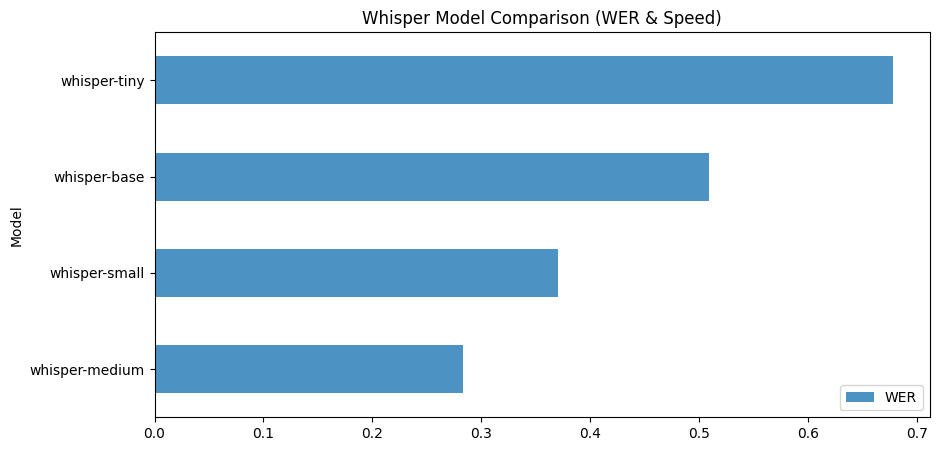

In [36]:
df_sorted.plot(
    kind="barh",
    x="Model",
    y=["WER"],
    title="Whisper Model Comparison (WER & Speed)",
    figsize=(10,5),
    alpha=0.8
)

In [37]:
df.to_csv('/kaggle/working/test.csv', index=False)